## Importing libraries

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Loading the preprocessed datasets

In [2]:
df_news=pd.read_csv("PC-news-data.csv") # news dataset
df_history=pd.read_csv("PC-behaviour-data.csv") # history dataset

In [3]:
df_news.head() 

,news_id,category,subcategory,title,abstract,tags,subcategory1
0,N55528,lifestyle,royals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",royals The Brands Queen Elizabeth Prince Charl...,royals
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,weightloss 50 Worst Habits For Belly Fat These...,weightloss
2,N61837,news,world,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,world The Cost Trump Aid Freeze Trenches Ukrai...,world
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",voices I Was An NBA Wife Here How It Affected ...,voices
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",medical How Get Rid Skin Tags According Dermat...,medical


In [4]:
df_history.head()

,user_id,history,category,subcategory
0,U13740,N55189,tv,news
1,U13740,N42782,sports,baseball mlb
2,U13740,N34694,tv,news
3,U13740,N45794,news,crime
4,U13740,N18445,sports,football ncaa


## Recommender system

##### A user has to enter it's choice of category

In [5]:
print('available categories: \n')
for cat in df_news.category.unique():
    print(cat)
input_category=input("\nEnter category: ")

available categories: 

lifestyle
health
news
sports
weather
entertainment
autos
travel
foodanddrink
tv
finance
movies
video
music
kids
middleeast
northamerica

Enter category: health


In [6]:
# filtering the news and history datasets based on the selected category
input_df=df_news[df_news.category==input_category]
input_history_df=df_history[df_history.category==input_category]
input_df.shape,input_history_df.shape

((1834, 7), (227302, 4))

##### A user has to enter it's choice of sub category from the selected category

In [9]:
print('available sub categories: \n')
for cat in input_df.subcategory.unique():
    print(cat)
input_subcategory=input("\nEnter sub category: ")

available sub categories: 

weightloss
voices
medical
nutrition
wellness
news
mental
fitness
ads lung
weight loss
agingwell
video
causes
pregnancyparenting
recipes
yliving
cancer
strength
cardio

Enter sub category: weightloss


In [14]:
# filtering the news and history datasets based on the selected category and subcategory
input_df_final=input_df[input_df.subcategory==input_subcategory]
input_history_df_final=input_history_df[input_history_df.subcategory==input_subcategory]
print(f"There are {input_df_final.shape[0]} news articles belonging to the {input_category} category and {input_subcategory} sub category")
print(f"There are {input_history_df_final.shape[0]} historical entries belonging to the {input_category} category and {input_subcategory} sub category")

There are 127 news articles belonging to the health category and weightloss sub category
There are 16698 historical entries belonging to the health category and weightloss sub category


### Recommending

The number of counts of news id has a huge range. So to keep it logical, I'll set a threshold so that no news id is given more weightage.

In [52]:
input_history_df_final[input_history_df_final.history=='N10280'].user_id.value_counts()

U74819    13
U18884     5
U69065     2
U42147     1
U74969     1
Name: user_id, dtype: int64

In [18]:
threshold_li=[]
for i in input_history_df_final.history.unique():
    val=input_history_df_final[input_history_df_final.history==i].user_id.value_counts().iloc[0]
    threshold_li.append(val)
threshold_val=np.round(np.mean(threshold_li))
threshold_val

13.0

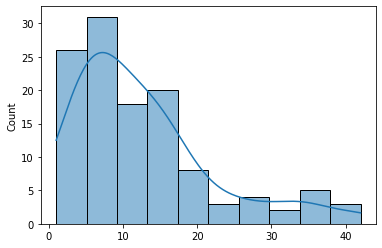

In [21]:
g=sns.histplot(threshold_li,kde=True)

The news id for which count is greater than the threshold value, the values will be replaced with the threshold value.

In [91]:
# filtering using threshold value
df_counts=input_history_df_final.groupby(['history','user_id']).user_id.count().to_frame().rename({'user_id':'counts'},axis=1)
df_counts=df_counts[df_counts<threshold_val].reset_index()
df_counts

,history,user_id,counts
0,N10280,U18884,5.0
1,N10280,U42147,1.0
2,N10280,U69065,2.0
3,N10280,U74819,NaN
4,N10280,U74969,1.0
...,...,...,...
3652,N9340,U71054,8.0
3653,N9340,U74763,2.0
3654,N9340,U8615,1.0
3655,N9340,U89208,9.0


In [92]:
# filling null values with threshold
df_counts.counts.fillna(threshold_val,inplace=True)
df_counts.head()

,history,user_id,counts
0,N10280,U18884,5.0
1,N10280,U42147,1.0
2,N10280,U69065,2.0
3,N10280,U74819,13.0
4,N10280,U74969,1.0


In [93]:
# creating a column user_score which is number of articles read by an user divided by the total number of counts
df_counts['user_score']=df_counts['counts']/np.sum(df_counts.counts)
df_counts.head()

,history,user_id,counts,user_score
0,N10280,U18884,5.0,0.000316
1,N10280,U42147,1.0,0.000063
2,N10280,U69065,2.0,0.000126
3,N10280,U74819,13.0,0.000821
4,N10280,U74969,1.0,0.000063


In [94]:
# calculating scores for news articles
news_score_dict=df_counts.history.value_counts(normalize=True).to_dict()
news_score_dict

{'N6342': 0.12359857806945584,
 'N17968': 0.07629204265791632,
 'N49944': 0.05906480721903199,
 'N64515': 0.05058791359037462,
 'N8082': 0.04457205359584359,
 'N33740': 0.04375170905113481,
 'N31983': 0.03472791905933825,
 'N1902': 0.030626196335794366,
 'N64541': 0.02871205906480722,
 'N62549': 0.022149302707136997,
 'N3820': 0.021875854525567406,
 'N36676': 0.020508613617719443,
 'N37549': 0.019414820891441073,
 'N17337': 0.019141372709871478,
 'N6576': 0.01804757998359311,
 'N52041': 0.01695378725731474,
 'N36440': 0.014492753623188406,
 'N13716': 0.013398960896910036,
 'N55856': 0.013125512715340444,
 'N64310': 0.012578616352201259,
 'N20741': 0.012305168170631665,
 'N35486': 0.012305168170631665,
 'N61055': 0.012031719989062073,
 'N24296': 0.01175827180749248,
 'N47059': 0.01175827180749248,
 'N64314': 0.01066447908121411,
 'N4848': 0.01066447908121411,
 'N13889': 0.010391030899644518,
 'N36851': 0.009844134536505332,
 'N33203': 0.009570686354935739,
 'N17975': 0.00902378999179655

In [95]:
# creating news score column containing the normalized value counts of news
df_counts['news_score']=df_counts.history.map(news_score_dict)
df_counts.head()

,history,user_id,counts,user_score,news_score
0,N10280,U18884,5.0,0.000316,0.001367
1,N10280,U42147,1.0,0.000063,0.001367
2,N10280,U69065,2.0,0.000126,0.001367
3,N10280,U74819,13.0,0.000821,0.001367
4,N10280,U74969,1.0,0.000063,0.001367


In [96]:
# calculating the final score that will be used for making recommendations
df_counts['score']=df_counts['user_score']*df_counts['news_score']
df_counts.head()

,history,user_id,counts,user_score,news_score,score
0,N10280,U18884,5.0,0.000316,0.001367,4.318512e-07
1,N10280,U42147,1.0,0.000063,0.001367,8.637024e-08
2,N10280,U69065,2.0,0.000126,0.001367,1.727405e-07
3,N10280,U74819,13.0,0.000821,0.001367,1.122813e-06
4,N10280,U74969,1.0,0.000063,0.001367,8.637024e-08


In [97]:
# sorting the score column
recs=df_counts.groupby(['history']).score.mean().to_frame().sort_values('score',ascending=False)
recs

,score
history,
N6342,3.553272e-05
N17968,2.212806e-05
N49944,1.601304e-05
N8082,1.388833e-05
N64515,1.261006e-05
...,...
N49275,3.454810e-08
N48877,3.454810e-08
N38336,1.727405e-08


In [98]:
# selecting top 10 news articles
rec_news_id=recs.iloc[:10].index.tolist()
rec_news_id

['N6342',
 'N17968',
 'N49944',
 'N8082',
 'N64515',
 'N33740',
 'N31983',
 'N1902',
 'N64541',
 'N36676']

In [99]:
# showing top 10 recommendations 
news_recommended=df_news[df_news.news_id.isin(rec_news_id)]
for idx,i in enumerate(news_recommended.title):
    print(idx+1,":",i,'\n')
sel_idx=int(input("\nSelect index: "))
sel_news=news_recommended.iloc[sel_idx-1]
print(f"\nNews: {sel_news.title}\n\nAbstract: {sel_news.abstract}")

1 : Can Drinking Beer Wreck Your Weight-Loss Progress From Your Workouts? 

2 : Jillian Michaels Says Intermittent Fasting 'Isn't Actually Good For Weight Loss' 

3 : Kelly Clarkson Talks About Her Weight Loss And Why It's All About Her Health 

4 : 'Pioneer Woman' star Ree Drummond shows off weight loss in new selfie 

5 : 5 Changes I Made in My Life to Lose Face Fat and Get Healthy 

6 : 24 Ways to Shrink Your Belly in 24 Hours 

7 : Jess Lost 75 Pounds Without Counting Calories and Did This 1 Inspiring Thing Before Every Meal 

8 : 'I Lost 125 Pounds By Making One Tiny Change Every Week' 

9 : Fit mother-of-four shares the simple approach that helped her lose 30kg WITHOUT dieting - and her tricks for staying on track while eating out 

10 : 'I Lost 125 Pounds And Now I'm A Bodybuilder' 


Select index: 1

News: Can Drinking Beer Wreck Your Weight-Loss Progress From Your Workouts?

Abstract: Maybe not: New research out of Spain shows that regularly drinking beer didn't influence the 

In [100]:
# selected news information
sel_news

news_id                                                     N8082
category                                                   health
subcategory                                            weightloss
title           Can Drinking Beer Wreck Your Weight-Loss Progr...
abstract        Maybe not: New research out of Spain shows tha...
tags            weightloss Can Drinking Beer Wreck Your Progre...
subcategory1                                           weightloss
Name: 9234, dtype: object

#### Content based recommendation

In [101]:
# filtering news dataframe with selected category and subcategory
df_con=df_news[(df_news.category==sel_news.category)&(df_news.subcategory==sel_news.subcategory)].reset_index(drop=True)
df_con.head()

,news_id,category,subcategory,title,abstract,tags,subcategory1
0,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,weightloss 50 Worst Habits For Belly Fat These...,weightloss
1,N15926,health,weightloss,These Simple Diet Changes Helped This Guy Lose...,The part of me that knew I had to make changes...,weightloss These Simple Diet Changes Helped Th...,weightloss
2,N60584,health,weightloss,Those Grueling Workouts May Not Help You Lose ...,"If you're trying to lose weight, you're probab...",weightloss Those Grueling Workouts May Not Hel...,weightloss
3,N24868,health,weightloss,Watch: Man Shares Time-Lapse Video of Six-Mont...,"We're big fans of weight-loss stories, but we ...",weightloss Watch Man Shares Video Journey We b...,weightloss
4,N16032,health,weightloss,"If You Have a Slow Metabolism, Here Are 5 Doct...","If you have a slow metabolism, trying to lose ...",weightloss If You Have Slow Metabolism Here Ar...,weightloss


In [102]:
# Bag of words
bow=CountVectorizer(max_features=5000)
vectors=bow.fit_transform(df_con['tags'])
similarity=cosine_similarity(vectors)

In [103]:
# selected news
c_input=sel_news.news_id
df_con[df_con.news_id == c_input]

,news_id,category,subcategory,title,abstract,tags,subcategory1
72,N8082,health,weightloss,Can Drinking Beer Wreck Your Weight-Loss Progr...,Maybe not: New research out of Spain shows tha...,weightloss Can Drinking Beer Wreck Your Progre...,weightloss


In [104]:
# function for making recommendations based on content and similarity score
def recommend(newd_id_c):
    news_index = df_con[df_con.news_id == newd_id_c].index[0]
    distance = similarity[news_index]
    news_list = sorted(list(enumerate(distance)), reverse=True,key=lambda x:x[1])[1:6]
    for i in news_list:
        print(df_con.iloc[i[0]].news_id,':',df_con.iloc[i[0]].title)
        print("Similarity score",i[1],'\n')

In [105]:
# top 5 recommendations
recommend(c_input)

N24494 : Not Sure Why Your Weight Is Fluctuating? These Weight-Management Doctors Have Answers
Similarity score 0.18208926018230742 

N31697 : 8 Ways You Can Literally Lose Weight in Your Sleep
Similarity score 0.16208817969462155 

N3820 : Jessica Simpson's Trainer Says She Wouldn't Have Lost As Much Weight If She'd Been Drinking
Similarity score 0.161627045958809 

N22061 : 28 Simple Ways to Shrink Your Gut
Similarity score 0.14888750009563956 

N64310 : Metabolic Testing Can Help You Lose Weight *If* You Know How To Interpret Your Results
Similarity score 0.1485562705416415 

